# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# Data

## Intake data

In [2]:
intake_url = "https://data.austintexas.gov/resource/wter-evkm.csv?$limit=500000"

In [3]:
df_intakes = pd.read_csv(intake_url)

## Outcome data

In [4]:
outcome_url = "https://data.austintexas.gov/resource/9t4d-g238.csv?$limit=500000"

In [5]:
df_outcomes = pd.read_csv(outcome_url)

# EDA

## Intake data

In [6]:
df_intakes.head()

,animal_id,name,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color
0,A521520,Nina,2013-10-01T07:51:00.000,2013-10-01T07:51:00.000,Norht Ec in Austin (TX),Stray,Normal,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan
1,A664235,NaN,2013-10-01T08:33:00.000,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
2,A664236,NaN,2013-10-01T08:33:00.000,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
3,A664237,NaN,2013-10-01T08:33:00.000,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
4,A664233,Stevie,2013-10-01T08:53:00.000,2013-10-01T08:53:00.000,7405 Springtime in Austin (TX),Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White


In [7]:
print(df_intakes['intake_type'].unique())

['Stray' 'Owner Surrender' 'Public Assist' 'Euthanasia Request' 'Wildlife'
 'Abandoned']


In [45]:
print(df_intakes['sex_upon_intake'].value_counts())

sex_upon_intake
Intact Male      57910
Intact Female    55827
Neutered Male    24147
Spayed Female    20262
Unknown           5784
Name: count, dtype: int64


In [38]:
#missing values by column
df_intakes.isnull().sum()

animal_id               0
name                41961
datetime                0
datetime2               0
found_location          0
intake_type             0
intake_condition        0
animal_type             0
sex_upon_intake         1
age_upon_intake         0
breed                   0
color                   0
monthyear               0
dtype: int64

In [39]:
print(df_intakes['age_upon_intake'].value_counts())

age_upon_intake
2 years      24993
1 year       24238
1 month      18112
2 months     10344
3 years       9241
4 weeks       5896
4 years       5726
5 years       5130
3 weeks       5103
3 months      4823
4 months      4679
5 months      3954
2 weeks       3578
6 years       3408
6 months      3006
7 years       2994
8 years       2820
7 months      2506
9 months      2446
10 years      2285
8 months      1968
9 years       1669
1 week        1459
1 weeks       1405
10 months     1370
0 years       1197
11 months     1121
12 years      1113
1 day          990
11 years       925
3 days         895
2 days         748
13 years       716
14 years       523
6 days         494
4 days         484
15 years       451
5 weeks        440
5 days         257
16 years       193
17 years       104
18 years        59
19 years        29
20 years        22
22 years         6
-1 years         5
-3 years         2
-2 years         1
24 years         1
-4 years         1
23 years         1
Name: count, dt

In [8]:
# Only keep Dog and Cat in animal_type
df_intakes = df_intakes[df_intakes['animal_type'].isin(['Dog', 'Cat'])]

In [11]:
print(df_intakes['intake_type'].value_counts())

intake_type
Stray                 117484
Owner Surrender        34475
Public Assist           9866
Abandoned               1863
Euthanasia Request       243
Wildlife                   1
Name: count, dtype: int64


In [12]:
df_intakes = df_intakes[df_intakes['intake_type'].isin(['Stray', 'Owner Surrender','Public Assist','Abandoned','Euthanasia Request'])]

In [15]:
# Extract monthyear from datetime column
df_intakes['datetime'] = pd.to_datetime(df_intakes['datetime'])
df_intakes['monthyear'] = df_intakes['datetime'].dt.to_period('M').astype(str)

# Group and count intakes
aggregated_intakes = (df_intakes.groupby(['animal_type', 'intake_type', 'monthyear'])
                               .size()
                               .reset_index(name='count'))

# Rename and reorder columns
aggregated_intakes = aggregated_intakes.rename(columns={'monthyear': 'date'})
aggregated_intakes = aggregated_intakes[['count', 'date', 'animal_type', 'intake_type']]

# Sort by date, then animal type
aggregated_intakes = aggregated_intakes.sort_values(['date', 'animal_type']).reset_index(drop=True)

In [16]:
aggregated_intakes.head(20)

,count,date,animal_type,intake_type
0,3,2013-10,Cat,Euthanasia Request
1,117,2013-10,Cat,Owner Surrender
2,3,2013-10,Cat,Public Assist
3,419,2013-10,Cat,Stray
4,9,2013-10,Dog,Euthanasia Request
5,174,2013-10,Dog,Owner Surrender
6,66,2013-10,Dog,Public Assist
7,716,2013-10,Dog,Stray
8,5,2013-11,Cat,Euthanasia Request
9,101,2013-11,Cat,Owner Surrender


In [17]:
aggregated_intakes['date'].nunique()

140

## Outcome data

In [18]:
df_outcomes.head()

,animal_id,date_of_birth,name,datetime,monthyear,outcome_type,outcome_subtype,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
0,A668305,2012-12-01,NaN,2013-12-02T00:00:00-05:00,12-2013,Transfer,Partner,Other,Unknown,1 year,Turtle Mix,Brown/Yellow
1,A673335,2012-02-22,NaN,2014-02-22T00:00:00-05:00,02-2014,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon,Black/Gray
2,A675999,2013-04-03,NaN,2014-04-07T00:00:00-05:00,04-2014,Transfer,Partner,Other,Unknown,1 year,Turtle Mix,Green
3,A679066,2014-04-16,NaN,2014-05-16T00:00:00-05:00,05-2014,NaN,NaN,Other,Unknown,4 weeks,Rabbit Sh,Brown
4,A680855,2014-05-25,NaN,2014-06-10T00:00:00-05:00,06-2014,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black


In [19]:
print(df_outcomes['outcome_type'].unique())

# Value counts for outcome_type
print(df_outcomes['outcome_type'].value_counts())

['Transfer' 'Euthanasia' nan 'Adoption' 'Return to Owner' 'Died' 'Missing'
 'Disposal' 'Relocate' 'Rto-Adopt' 'Stolen' 'Lost']
outcome_type
Adoption           84598
Transfer           48689
Return to Owner    25691
Euthanasia         10833
Died                1672
Rto-Adopt           1241
Disposal             877
Missing               92
Relocate              29
Stolen                 5
Lost                   2
Name: count, dtype: int64


In [46]:
print(df_outcomes['sex_upon_outcome'].value_counts())

sex_upon_outcome
Neutered Male    60684
Spayed Female    55059
Intact Male      21184
Intact Female    20912
Unknown           5665
Name: count, dtype: int64


In [50]:
breed_df = df_outcomes['breed'].value_counts()
breed_df.head(20)

breed
Domestic Shorthair Mix       33980
Domestic Shorthair           23707
Pit Bull Mix                 10127
Labrador Retriever Mix        8801
Chihuahua Shorthair Mix       6914
German Shepherd Mix           4050
Pit Bull                      3384
Domestic Medium Hair Mix      3373
Domestic Medium Hair          2084
Labrador Retriever            2025
Chihuahua Shorthair           2004
Australian Cattle Dog Mix     1991
German Shepherd               1818
Domestic Longhair Mix         1687
Siamese Mix                   1470
Dachshund Mix                 1190
Boxer Mix                     1184
Border Collie Mix             1149
Siberian Husky Mix             974
Miniature Poodle Mix           926
Name: count, dtype: int64

In [49]:
print(df_outcomes['breed'].nunique())

2768


In [20]:
df_outcomes = df_outcomes[df_outcomes['animal_type'].isin(['Dog', 'Cat'])]

In [21]:
df_outcomes = df_outcomes[df_outcomes['outcome_type'].isin(['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Died','Rto-Adopt'])]

In [22]:
# Clean column names
df_outcomes.columns = df_outcomes.columns.str.strip()

# Handle different column name formats
df_outcomes_ts = df_outcomes.rename(columns={
    'Animal Type': 'animal_type',
    'Outcome Type': 'outcome_type', 
    'MonthYear': 'monthyear'
})

# Group and count
aggregated_df_outcomes = (df_outcomes_ts.groupby(['animal_type', 'outcome_type', 'monthyear'])
                  .size()
                  .reset_index(name='count'))

# Rename and reorder columns
aggregated_df_outcomes = aggregated_df_outcomes.rename(columns={'monthyear': 'date'})
aggregated_df_outcomes = aggregated_df_outcomes[['count', 'animal_type', 'outcome_type', 'date']]

# Sort by date, then animal type
aggregated_df_outcomes = aggregated_df_outcomes.sort_values(['date', 'animal_type']).reset_index(drop=True)

In [23]:
aggregated_df_outcomes.head(20)

,count,animal_type,outcome_type,date
0,159,Cat,Adoption,01-2014
1,1,Cat,Died,01-2014
2,23,Cat,Euthanasia,01-2014
3,38,Cat,Return to Owner,01-2014
4,146,Cat,Transfer,01-2014
5,359,Dog,Adoption,01-2014
6,3,Dog,Died,01-2014
7,45,Dog,Euthanasia,01-2014
8,248,Dog,Return to Owner,01-2014
9,204,Dog,Transfer,01-2014


# Plots

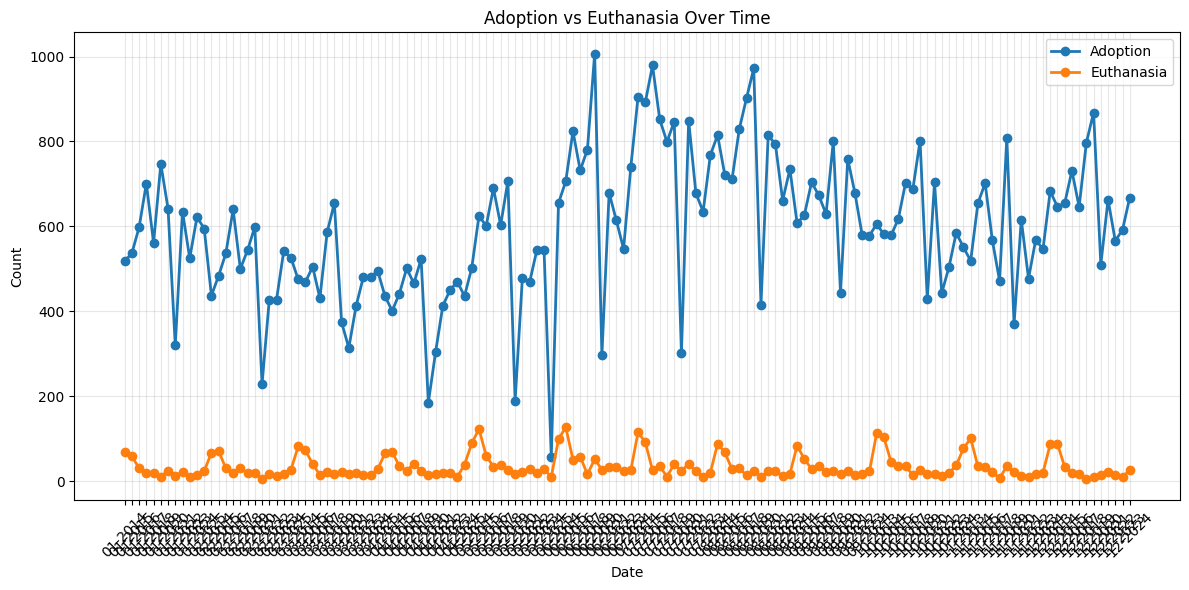

In [24]:
# Filter for Adoption and Euthanasia outcomes
filtered_df = aggregated_df_outcomes[aggregated_df_outcomes['outcome_type'].isin(['Adoption', 'Euthanasia'])]

# Aggregate by month and outcome_type
monthly_outcomes = (filtered_df.groupby(['date', 'outcome_type'])['count']
                              .sum()
                              .reset_index())

# Pivot for plotting
pivot_df = monthly_outcomes.pivot(index='date', columns='outcome_type', values='count')
pivot_df = pivot_df.fillna(0)

# Create line chart
plt.figure(figsize=(12, 6))
for outcome in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[outcome], marker='o', label=outcome, linewidth=2)

plt.title('Adoption vs Euthanasia Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

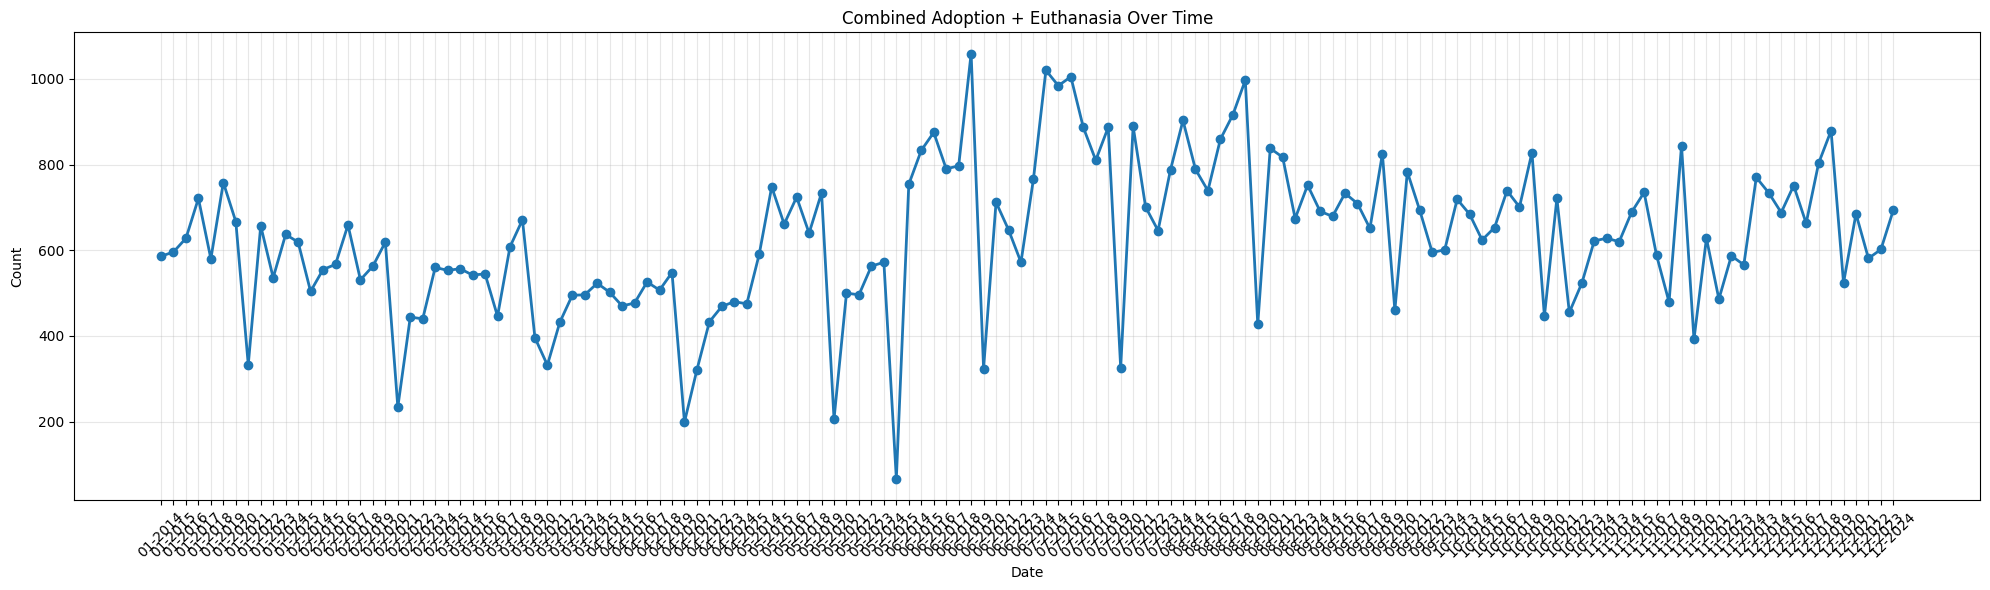

In [ ]:
# Filter for Adoption and Euthanasia outcomes
filtered_df = aggregated_df_outcomes[aggregated_df_outcomes['outcome_type'].isin(['Adoption', 'Euthanasia'])]

# Aggregate by month (sum both outcome types)
monthly_total = (filtered_df.groupby('date')['count']
                           .sum()
                           .reset_index())

# Create line chart
plt.figure(figsize=(20, 6))
plt.plot(monthly_total['date'], monthly_total['count'], marker='o', linewidth=2)

plt.title('Combined Adoption + Euthanasia Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

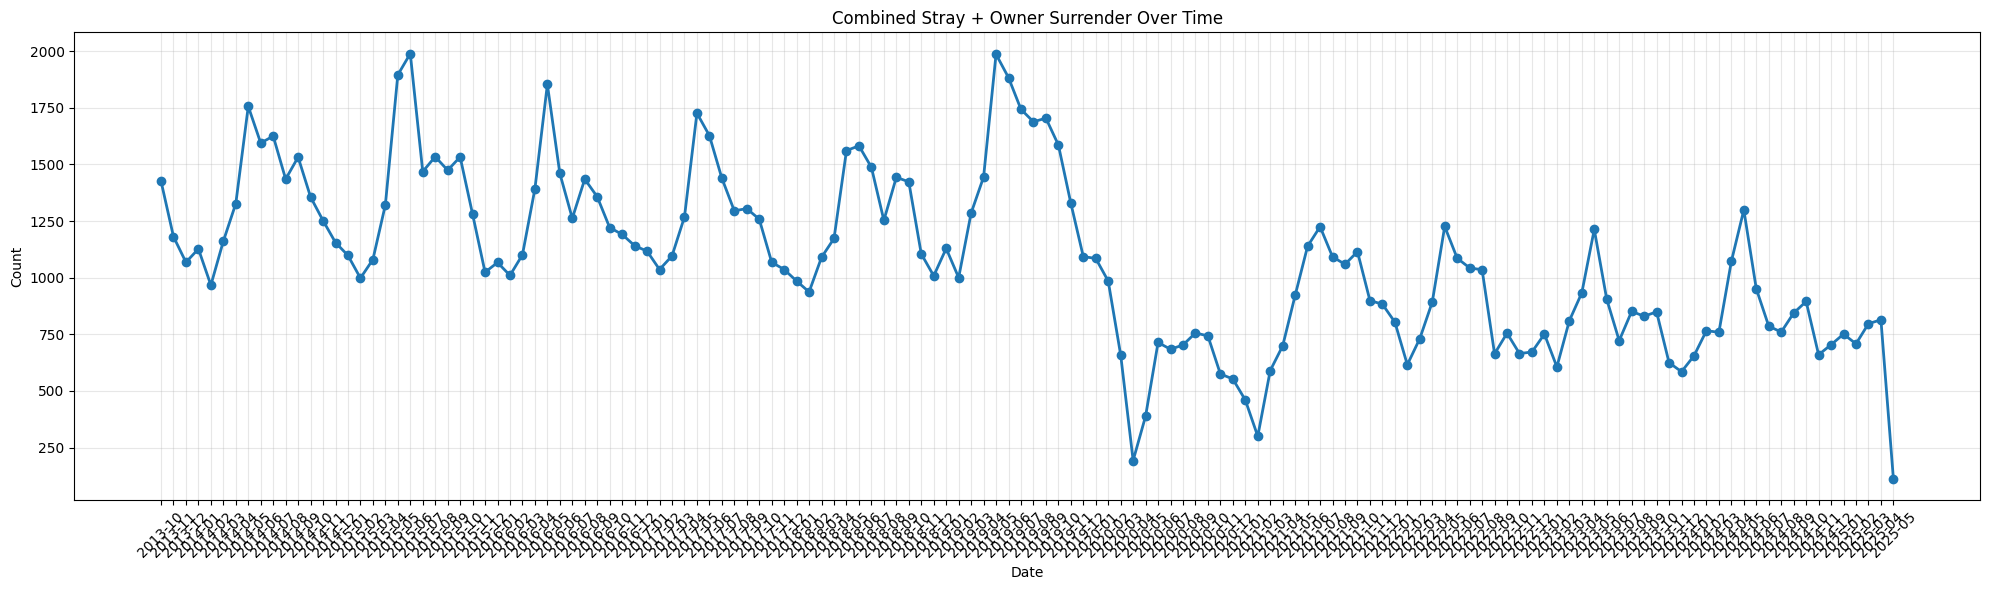

In [30]:
# Filter for Adoption and Euthanasia outcomes
filtered_df = aggregated_intakes[aggregated_intakes['intake_type'].isin(['Stray', 'Owner Surrender'])]

# Aggregate by month (sum both outcome types)
monthly_total = (filtered_df.groupby('date')['count']
                           .sum()
                           .reset_index())

# Create line chart
plt.figure(figsize=(20, 6))
plt.plot(monthly_total['date'], monthly_total['count'], marker='o', linewidth=2)

plt.title('Combined Stray + Owner Surrender Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Preprocessing